In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from datetime import datetime
import os
import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from scipy import sparse
from scipy.sparse import csc_matrix
from sklearn.decomposition import TruncatedSVD
import random
random.seed(0)
np.random.seed(0)

## Analyse Dataset

### Amazon product review   Dataset
- https://www.kaggle.com/datasets/saurav9786/amazon-product-reviews?resource=download

In [3]:
!pip install gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
!gdown https://drive.google.com/uc?id=1dFuCcqIO0_vQcNg_47Ondz3akBG1ojzb

Downloading...
From: https://drive.google.com/uc?id=1dFuCcqIO0_vQcNg_47Ondz3akBG1ojzb
To: /content/ratings_Electronics.csv
100% 319M/319M [00:01<00:00, 228MB/s]


#### Consider movies rated by more than 200 users

In [5]:
rating_df =pd.read_csv('ratings_Electronics.csv',  names=['userId','item','rating','time'])
rating_df=rating_df[['userId','item','rating','time']]

x = rating_df.groupby('userId').count()['rating'] >= 30
userIndex = x[x].index
nm_rating_df=rating_df[rating_df['userId'].isin(userIndex)]
y = nm_rating_df.groupby('item').count()['rating']>=30
items = y[y].index
rating_df = nm_rating_df[nm_rating_df['item'].isin(items)]
rating_df.shape

(51702, 4)

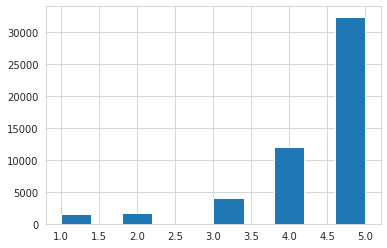

In [6]:
rating_df['rating'].hist()

### Prepare train test set

In [7]:
final_ratings=rating_df.sort_values(by=['userId','time','rating'], ascending=[False,False,False]) 
final_ratings.shape

(51702, 4)

In [8]:
test_df=final_ratings.groupby('userId').head(10)
test_df.shape

(37368, 4)

In [9]:
final_ratings=final_ratings[~final_ratings.isin(test_df).all(1)]
final_ratings.shape

(14334, 4)

In [10]:
graph_df=final_ratings
graph_df=graph_df[['userId','item','rating']]
graph_df.columns = ['source', 'target', 'weights']
graph_df.head(1)

,source,target,weights
1948777,AZYJE40XW6MFG,B001E1Y5O6,5.0


In [11]:
test_df.head(1)

,userId,item,rating,time
2307829,AZZYW4YOE1B6E,B001TH7GUA,5.0,1404172800


## Graph Embeddings


#### Install packages

In [ ]:
!pip install networkx
!pip install stellargraph
!pip install gensim

###  Step1: Create the rating matrix with rows as movies and columns as users.

In [13]:
import networkx as nx

### Create a weighted graph of user Item using python library networkx, stellargraph
- https://snap.stanford.edu/node2vec/
- https://github.com/aditya-grover/node2vec

- https://towardsdatascience.com/complete-guide-to-understanding-node2vec-algorithm-4e9a35e5d147
- https://towardsdatascience.com/node2vec-explained-db86a319e9ab
- https://github.com/stellargraph/stellargraph

In [14]:
from stellargraph.data import BiasedRandomWalk
from stellargraph import StellarGraph

In [15]:
G = StellarGraph(edges=graph_df)

In [16]:
rw = BiasedRandomWalk(G)

walks = rw.run(
    nodes=list(G.nodes()),  # root nodes
    length=80,  # maximum length of a random walk
    n=10,  # number of random walks per root node
    p=0.5,  # Defines (unormalised) probability, 1/p, of returning to source node
    q=2.0,  # Defines (unormalised) probability, 1/q, for moving away from source node
)
print("Number of random walks: {}".format(len(walks)))

Number of random walks: 26570


#### compute random walk

In [17]:

from gensim.models import Word2Vec

str_walks = [[str(n) for n in walk] for walk in walks]
model = Word2Vec(str_walks, size=128, window=5, min_count=0, sg=1, workers=2, iter=1)

#### Save model and use for recommendation

In [18]:
model.save("word2vec.model")

In [19]:
model = Word2Vec.load("word2vec.model")

In [20]:
node_embeddings= model.wv

In [21]:
import networkx as nx

In [22]:
user_item_edge_list = graph_df[['source', 'target', 'weights']]
user_item_edge_list.head()

,source,target,weights
1948777,AZYJE40XW6MFG,B001E1Y5O6,5.0
2331440,AZYJE40XW6MFG,B001TZWNF0,5.0
327285,AZYJE40XW6MFG,B0000BVYTV,4.0
518115,AZYJE40XW6MFG,B0002Y5WZM,5.0
453184,AZYJE40XW6MFG,B0002CPBWI,5.0


In [23]:
from sklearn.metrics.pairwise import cosine_similarity


In [24]:
df=user_item_edge_list['target'].unique()

In [25]:
df=list(df)
df.sort()


## Evaluate our result
- We will generate top 10 recommendations for 100 user and calculate the hit rate in test data set.

In [32]:
userlist=list(graph_df.source.unique())[:100]

In [37]:
data=final_ratings[final_ratings['userId'].isin(userlist)]

In [28]:
test_df=test_df[test_df['userId'].isin(userlist)]

In [40]:
result=final_ratings.sort_values(by=['userId','time'],ascending=[True,False])
result=result.groupby('userId').head(10)

In [41]:
result.head(1)

,userId,item,rating,time
4172527,A100UD67AHFODS,B004I5BUSO,5.0,1353024000


In [43]:
from collections import Counter
from scipy.spatial.distance import cosine
top_n = 10
k = 50
top_n = 10

recommend_dict = { }
for index, row in result.iterrows():
    user=row['userId']
    if user not in recommend_dict.keys():
        recommend_dict[user]={}
    
    pid=row['item'] 
    product1 = pid
    res_dict= {}
    for i in df:
      if(i!=pid):
        product2 = i
        cos=1.0 - cosine(node_embeddings[product1], node_embeddings[product2])
        res_dict[i]=cos
    
    res=dict(Counter(res_dict).most_common(10))
    indexes= list(res.keys())    
    
  
    for ids in indexes:
        if(ids==pid):
            continue
        if(~((result['item'] == ids) & (result['userId'] ==user)).any()):
            if ids not in recommend_dict[user].keys():
                recommend_dict[user][ids] =1
            else:
                recommend_dict[user][ids]+=1
                    
        
    
        
        

In [44]:
# Iterating over values
recommendations=[]
for userid, products in recommend_dict.items():
    total=0
    mlist=[]
    for i in products:
        total+=1
        mlist.append(i)
        if(total>15):
            break
    recommendations.append([userid,mlist])

In [45]:
recommendations=pd.DataFrame(recommendations,columns=['user_id','products'])

### Calculate Hit Ratio
- See how often we recommended a movie the user actually rated

In [46]:
total=0
hit=0
for i in userlist:
    results=recommendations[recommendations.user_id==i]
    results=list(results.products)[0]
    total+=1
    for rs in results:
        
        if(((test_df['item'] == rs) & (test_df['userId'] ==i)).any()):
                hit+=1
                break
        
hit_ratio=hit/total   
print(hit_ratio)

0.22


### MAP@K

In [47]:
total=0
hit=0
for i in userlist:
    results=recommendations[recommendations.user_id==i]
    results=list(results.products)[0]
   
    for rs in results:
        total+=1
        if(((test_df['item'] == rs) & (test_df['userId'] ==i)).any()):
                hit+=1
                
        
mapk=hit/total   
print(mapk)

0.01742627345844504
